In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import zipfile
import numpy as np
from PIL import Image

In [ ]:
# @title   ==================== Конфигурация ====================
class Config:
    # Размеры
    target_size = 448
    input_channels = 1
    latent_dim = 32

    # Архитектура
    hidden_dims = [32, 64, 128, 256]

    # Обучение
    batch_size = 16
    learning_rate = 1e-5
    epochs = 20
    beta = 1.0  # Вес для KL дивергенции
    beta_start = 0.0
    beta_end = 1.0
    warmup_epochs = 5

    # Пути
    data_dir = "./data/"
    model_save_path = "./vae_model.pth"

    # Устройство
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()

In [ ]:
# !gdown 14iWIOtUvTRoga_rzV0hchXMznGl588E4
!gdown 1LAdZFM5rwicz_zg4RqiyphvfS2Psz2QM

Downloading...
From (original): https://drive.google.com/uc?id=1LAdZFM5rwicz_zg4RqiyphvfS2Psz2QM
From (redirected): https://drive.google.com/uc?id=1LAdZFM5rwicz_zg4RqiyphvfS2Psz2QM&confirm=t&uuid=fc98eea1-6106-40a2-8fd9-7c88541dbbab
To: /content/Image_seg_archive_9-patches_overlap=0.5.zip
100% 151M/151M [00:02<00:00, 59.9MB/s]


In [ ]:
# input = './archive_images_overlap=0.5.zip'
input = 'Image_seg_archive_9-patches_overlap=0.5.zip'
dir_input = './data'

os.makedirs(dir_input, exist_ok=True)

with zipfile.ZipFile(input, 'r') as zip_ref:
      print(f'unzip: {input}')
      zip_ref.extractall(dir_input)

unzip: Image_seg_archive_9-patches_overlap=0.5.zip


In [ ]:
# @title   ==================== Dataset Class ====================
class SurfaceDataset(Dataset):
    def __init__(self, data_dir, target_size=448):
        self.data_dir = Path(data_dir)
        self.target_size = target_size
        self.file_paths = []
        self.labels = []
        self.label_map = {
            'pristine_fine': 0,
            'pristine_medium': 1,
            'pristine_coarse': 2,
            'degraded_fine': 3,
            'degraded_medium': 4,
            'degraded_coarse': 5
        }

        # Сбор всех .npy файлов
        for file_path in glob.glob(str(self.data_dir / "*.npy")):
            filename = Path(file_path).stem
            for label_key in self.label_map.keys():
                if label_key in filename:
                    self.file_paths.append(file_path)
                    self.labels.append(self.label_map[label_key])
                    break

        print(f"Found {len(self.file_paths)} samples")
        print(f"Class distribution: {np.bincount(self.labels)}")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Загрузка данных
        data = np.load(self.file_paths[idx])

        # Предобработка: нормализация и изменение размера
        if data.ndim == 2:
            data = data[np.newaxis, ...]  # Добавляем channel dimension
        elif data.ndim == 3 and data.shape[0] == 1:
            pass  # Уже правильная форма
        else:
            raise ValueError(f"Unexpected data shape: {data.shape}")

        # Изменение размера если нужно
        if data.shape[-2:] != (self.target_size, self.target_size):
            # Используем torch для ресайза (можно заменить на другие методы)
            data_tensor = torch.from_numpy(data).float()
            data_resized = F.interpolate(
                data_tensor.unsqueeze(0),
                size=(self.target_size, self.target_size),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)
            data = data_resized.numpy()

        # Нормализация к [0, 1]
        data_min = 0
        data_max = 2
        if data_max - data_min > 0:
            data = (data - data_min) / (data_max - data_min)

        # Преобразование в тензор
        data_tensor = torch.from_numpy(data).float()
        label = self.labels[idx]

        return data_tensor, label, Path(self.file_paths[idx]).name

In [ ]:
# @title   ==================== VAE Model ====================
class VAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=32, hidden_dims=None):
        super(VAE, self).__init__()

        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256]

        self.latent_dim = latent_dim

        # Encoder
        modules = []
        in_features = in_channels

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_features, h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(0.2)
                )
            )
            in_features = h_dim

        self.encoder = nn.Sequential(*modules)

        # Вычисляем размер латентного пространства
        with torch.no_grad():
            sample = torch.randn(1, in_channels, config.target_size, config.target_size)
            sample = self.encoder(sample)
            self.encoded_size = sample.shape[1:]
            flat_size = sample.view(1, -1).shape[1]

        # Латентные слои
        self.fc_mu = nn.Linear(flat_size, latent_dim)
        self.fc_var = nn.Linear(flat_size, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, flat_size)

        # Decoder
        modules = []

        hidden_dims_rev = hidden_dims[::-1]

        for i in range(len(hidden_dims_rev) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims_rev[i],
                                       hidden_dims_rev[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims_rev[i + 1]),
                    nn.LeakyReLU(0.2)
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims_rev[-1],
                               hidden_dims_rev[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims_rev[-1]),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_dims_rev[-1], in_channels,
                     kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        print(f"Encoder output shape: {self.encoded_size}")
        print(f"Flatten size: {flat_size}")

    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        logvar = self.fc_var(result)
        # Стабилизация: clamp logvar [-10, 2] → std [0.000045, 7.4], exp<1000
        logvar = torch.clamp(logvar, min=-10.0, max=2.0)
        return mu, logvar

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, *self.encoded_size)
        result = self.decoder(result)
        result = self.final_layer(result)

        # Обрезка до исходного размера если нужно
        if result.shape[-2:] != (config.target_size, config.target_size):
            result = F.interpolate(
                result,
                size=(config.target_size, config.target_size),
                mode='bilinear',
                align_corners=False
            )

        return result

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var

In [ ]:
# @title   ==================== Loss Function ====================
def vae_loss(recon_x, x, mu, log_var, beta=1.0):
    # Reconstruction loss (MSE или BCE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / (recon_x.size(0) * recon_x.size(1) * recon_x.size(2) * recon_x.size(3))
    # KL
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()
    # NaN guard
    if torch.isnan(kl_loss) or torch.isinf(kl_loss):
        kl_loss = torch.tensor(1e4, device=kl_loss.device)
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

In [ ]:
# @title   ==================== Training Function ====================
def train_vae(model, train_loader, val_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate,weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10)

    train_losses = []
    val_losses = []

    for epoch in range(config.epochs):
        # Training
        model.train()
        train_loss = 0
        train_recon_loss = 0
        train_kl_loss = 0

        beta = min(config.beta_end, config.beta_start + (config.beta_end - config.beta_start) * epoch / config.warmup_epochs)

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.epochs}")
        for batch_idx, (data, _, _) in enumerate(pbar):
            data = data.to(config.device)
            optimizer.zero_grad()

            recon_batch, mu, log_var = model(data)
            loss, recon_loss, kl_loss = vae_loss(
                recon_batch, data, mu, log_var, beta=beta) #config.beta
            # )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_recon_loss += recon_loss.item()
            train_kl_loss += kl_loss.item()

            pbar.set_postfix({
                'loss': loss.item(),
                'recon': recon_loss.item(),
                'kl': kl_loss.item(),
                'log_var_mean': log_var.mean().item(),
                'log_var_std': log_var.std().item()
                })

        avg_train_loss = train_loss / len(train_loader)
        avg_train_recon = train_recon_loss / len(train_loader)
        avg_train_kl = train_kl_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _, _ in val_loader:
                data = data.to(config.device)
                recon_batch, mu, log_var = model(data)
                loss, _, _ = vae_loss(
                    recon_batch, data, mu, log_var, beta=config.beta
                )
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"\nEpoch {epoch+1}:")
        print(f"  Train Loss: {avg_train_loss:.4f} "
              f"(Recon: {avg_train_recon:.4f}, KL: {avg_train_kl:.4f})")
        print(f"  Val Loss: {avg_val_loss:.4f}")

        # Сохраняем модель каждые 5 эпох
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_val_loss,
            }, f"./vae_checkpoint_epoch_{epoch+1}.pth")

    # Сохраняем финальную модель
    torch.save(model.state_dict(), config.model_save_path)

    return train_losses, val_losses

In [ ]:
# @title  ==================== Visualization Functions ====================
def visualize_latent_space(model, data_loader, config, method='tsne'):
    """Визуализация латентного пространства"""
    model.eval()
    all_latents = []
    all_labels = []
    all_filenames = []

    with torch.no_grad():
        for data, labels, filenames in data_loader:
            data = data.to(config.device)
            mu, _ = model.encode(data)
            all_latents.append(mu.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_filenames.extend(filenames)

    all_latents = np.vstack(all_latents)
    all_labels = np.array(all_labels)

    # Обратное отображение для названий классов
    label_names = {
        0: 'pristine_fine',
        1: 'pristine_medium',
        2: 'pristine_coarse',
        3: 'degraded_fine',
        4: 'degraded_medium',
        5: 'degraded_coarse'
    }

    # Применяем метод снижения размерности
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        latents_2d = reducer.fit_transform(all_latents)
    elif method == 'pca':
        reducer = PCA(n_components=2)
        latents_2d = reducer.fit_transform(all_latents)
    else:
        raise ValueError("Method should be 'tsne' or 'pca'")

    # Создаем визуализацию
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. По основным категориям (pristine/degraded)
    categories = ['pristine' if x < 3 else 'degraded' for x in all_labels]
    unique_cats = list(set(categories))
    cat_colors = {'pristine': 'blue', 'degraded': 'red'}

    for cat in unique_cats:
        mask = [c == cat for c in categories]
        axes[0].scatter(latents_2d[mask, 0], latents_2d[mask, 1],
                       label=cat, alpha=0.6, s=20)
    axes[0].set_title(f'Latent Space ({method.upper()}) - Pristine vs Degraded')
    axes[0].set_xlabel('Component 1')
    axes[0].set_ylabel('Component 2')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. По всем 6 классам
    for label_id in range(6):
        mask = all_labels == label_id
        axes[1].scatter(latents_2d[mask, 0], latents_2d[mask, 1],
                       label=label_names[label_id], alpha=0.6, s=20)
    axes[1].set_title(f'Latent Space ({method.upper()}) - All Classes')
    axes[1].set_xlabel('Component 1')
    axes[1].set_ylabel('Component 2')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'latent_space_{method}.png', dpi=150, bbox_inches='tight')
    plt.show()

    return all_latents, all_labels, latents_2d

def visualize_reconstructions(model, data_loader, config, num_samples=5):
    """Визуализация реконструкций"""
    model.eval()
    samples = []

    with torch.no_grad():
        for data, labels, filenames in data_loader:
            data = data.to(config.device)
            recon, _, _ = model(data)

            # Сохраняем несколько примеров
            for i in range(min(num_samples, data.size(0))):
                samples.append({
                    'original': data[i].cpu().numpy(),
                    'reconstruction': recon[i].cpu().numpy(),
                    'label': labels[i].item(),
                    'filename': filenames[i]
                })
            if len(samples) >= num_samples:
                break

    # Отображаем реконструкции
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    label_names = {
        0: 'pristine_fine',
        1: 'pristine_medium',
        2: 'pristine_coarse',
        3: 'degraded_fine',
        4: 'degraded_medium',
        5: 'degraded_coarse'
    }

    for i in range(num_samples):
        # Оригинал
        axes[0, i].imshow(samples[i]['original'].squeeze(), cmap='gray')
        axes[0, i].set_title(f"Original\n{label_names[samples[i]['label']]}")
        axes[0, i].axis('off')

        # Реконструкция
        axes[1, i].imshow(samples[i]['reconstruction'].squeeze(), cmap='gray')
        axes[1, i].set_title(f"Reconstruction")
        axes[1, i].axis('off')

    plt.suptitle('Original vs Reconstructed Images', fontsize=16)
    plt.tight_layout()
    plt.savefig('reconstructions.png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
# @title   ==================== Main Execution ====================
def main():
    print(f"Using device: {config.device}")
    print(f"Target image size: {config.target_size}x{config.target_size}")

    # Создаем dataset и dataloaders
    dataset = SurfaceDataset(config.data_dir, target_size=config.target_size)

    # Разделение на train/val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
    )

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

    # Создаем модель
    model = VAE(
        in_channels=config.input_channels,
        latent_dim=config.latent_dim,
        hidden_dims=config.hidden_dims
    ).to(config.device)

    print(f"Model architecture:")
    print(model)
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Обучение
    print("\nStarting training...")
    train_losses, val_losses = train_vae(model, train_loader, val_loader, config)

    # Визуализация кривых обучения
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Визуализация латентного пространства
    print("\nVisualizing latent space...")
    full_loader = DataLoader(
        dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
    )

    # t-SNE визуализация
    latents, labels, latents_2d = visualize_latent_space(
        model, full_loader, config, method='tsne'
    )

    # PCA визуализация
    latents, labels, latents_2d = visualize_latent_space(
        model, full_loader, config, method='pca'
    )

    # Визуализация реконструкций
    print("\nVisualizing reconstructions...")
    visualize_reconstructions(model, val_loader, config, num_samples=5)

    # Анализ латентного пространства
    print("\nLatent Space Analysis:")
    print(f"Latent vectors shape: {latents.shape}")

    # Вычисляем расстояния между классами
    label_names = ['pristine_fine', 'pristine_medium', 'pristine_coarse',
                   'degraded_fine', 'degraded_medium', 'degraded_coarse']

    for i in range(6):
        for j in range(i+1, 6):
            mask_i = labels == i
            mask_j = labels == j

            if np.sum(mask_i) > 0 and np.sum(mask_j) > 0:
                centroid_i = np.mean(latents[mask_i], axis=0)
                centroid_j = np.mean(latents[mask_j], axis=0)
                distance = np.linalg.norm(centroid_i - centroid_j)
                print(f"Distance between {label_names[i]:<20} and {label_names[j]:<20}: {distance:.4f}")

Using device: cuda
Target image size: 448x448
Found 24192 samples
Class distribution: [4032 4032 4032 4032 4032 4032]
Train samples: 19353, Val samples: 4839
Encoder output shape: torch.Size([256, 28, 28])
Flatten size: 200704
Model architecture:
VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Seque

Epoch 1/20: 100%|██████████| 1210/1210 [04:17<00:00,  4.70it/s, loss=0.101, recon=0.101, kl=499, log_var_mean=-9.64, log_var_std=0.622]



Epoch 1:
  Train Loss: 0.1366 (Recon: 0.1366, KL: 306.3324)
  Val Loss: 494.5470


Epoch 2/20: 100%|██████████| 1210/1210 [04:18<00:00,  4.68it/s, loss=2.88, recon=0.184, kl=13.5, log_var_mean=0.363, log_var_std=0.794]



Epoch 2:
  Train Loss: 3.7367 (Recon: 0.1890, KL: 17.7386)
  Val Loss: 13.7457


Epoch 3/20: 100%|██████████| 1210/1210 [04:18<00:00,  4.67it/s, loss=5.56, recon=0.173, kl=13.5, log_var_mean=0.373, log_var_std=0.789]



Epoch 3:
  Train Loss: 5.5471 (Recon: 0.1639, KL: 13.4582)
  Val Loss: 13.5799


Epoch 4/20: 100%|██████████| 1210/1210 [04:19<00:00,  4.66it/s, loss=8.17, recon=0.166, kl=13.3, log_var_mean=0.359, log_var_std=0.793]



Epoch 4:
  Train Loss: 8.1953 (Recon: 0.1627, KL: 13.3876)
  Val Loss: 13.5284


Epoch 5/20: 100%|██████████| 1210/1210 [04:18<00:00,  4.68it/s, loss=9.07, recon=0.152, kl=11.1, log_var_mean=0.299, log_var_std=0.738]



Epoch 5:
  Train Loss: 10.3176 (Recon: 0.1624, KL: 12.6939)
  Val Loss: 11.3516


Epoch 6/20: 100%|██████████| 1210/1210 [04:21<00:00,  4.63it/s, loss=11.3, recon=0.16, kl=11.1, log_var_mean=0.302, log_var_std=0.736]



Epoch 6:
  Train Loss: 11.3168 (Recon: 0.1623, KL: 11.1544)
  Val Loss: 11.3097


Epoch 7/20: 100%|██████████| 1210/1210 [04:19<00:00,  4.66it/s, loss=0.292, recon=0.149, kl=0.143, log_var_mean=-0.0193, log_var_std=0.0972]



Epoch 7:
  Train Loss: 10.1964 (Recon: 0.1623, KL: 10.0341)
  Val Loss: 0.3462


Epoch 8/20: 100%|██████████| 1210/1210 [04:19<00:00,  4.66it/s, loss=0.372, recon=0.155, kl=0.217, log_var_mean=0.018, log_var_std=0.0854]



Epoch 8:
  Train Loss: 0.3270 (Recon: 0.1622, KL: 0.1648)
  Val Loss: 0.3549


Epoch 9/20: 100%|██████████| 1210/1210 [04:18<00:00,  4.68it/s, loss=0.323, recon=0.166, kl=0.157, log_var_mean=-0.00491, log_var_std=0.0901]



Epoch 9:
  Train Loss: 0.3130 (Recon: 0.1622, KL: 0.1508)
  Val Loss: 0.3289


Epoch 10/20: 100%|██████████| 1210/1210 [04:19<00:00,  4.66it/s, loss=0.27, recon=0.161, kl=0.109, log_var_mean=-0.00449, log_var_std=0.0648]



Epoch 10:
  Train Loss: 0.3009 (Recon: 0.1621, KL: 0.1387)
  Val Loss: 0.2717


Epoch 11/20: 100%|██████████| 1210/1210 [04:18<00:00,  4.67it/s, loss=0.285, recon=0.164, kl=0.121, log_var_mean=0.013, log_var_std=0.0663]



Epoch 11:
  Train Loss: 0.2917 (Recon: 0.1621, KL: 0.1295)
  Val Loss: 0.3212


Epoch 12/20: 100%|██████████| 1210/1210 [04:18<00:00,  4.68it/s, loss=0.282, recon=0.175, kl=0.107, log_var_mean=-0.0141, log_var_std=0.0647]



Epoch 12:
  Train Loss: 0.2882 (Recon: 0.1621, KL: 0.1260)
  Val Loss: 0.2628


Epoch 13/20: 100%|██████████| 1210/1210 [04:18<00:00,  4.68it/s, loss=0.295, recon=0.173, kl=0.122, log_var_mean=-0.00422, log_var_std=0.0682]



Epoch 13:
  Train Loss: 0.2809 (Recon: 0.1621, KL: 0.1188)
  Val Loss: 0.2784


Epoch 14/20: 100%|██████████| 1210/1210 [04:18<00:00,  4.68it/s, loss=0.278, recon=0.158, kl=0.12, log_var_mean=0.00898, log_var_std=0.0714]



Epoch 14:
  Train Loss: 0.2769 (Recon: 0.1621, KL: 0.1149)
  Val Loss: 0.2745


Epoch 15/20: 100%|██████████| 1210/1210 [04:18<00:00,  4.68it/s, loss=0.278, recon=0.168, kl=0.109, log_var_mean=-0.0106, log_var_std=0.0626]



Epoch 15:
  Train Loss: 0.2744 (Recon: 0.1620, KL: 0.1123)
  Val Loss: 0.2667


Epoch 16/20: 100%|██████████| 1210/1210 [04:19<00:00,  4.66it/s, loss=0.275, recon=0.163, kl=0.112, log_var_mean=0.00421, log_var_std=0.0637]



Epoch 16:
  Train Loss: 0.2735 (Recon: 0.1620, KL: 0.1116)
  Val Loss: 0.2767


Epoch 17/20: 100%|██████████| 1210/1210 [04:19<00:00,  4.66it/s, loss=0.24, recon=0.156, kl=0.084, log_var_mean=-0.00702, log_var_std=0.0572]



Epoch 17:
  Train Loss: 0.2682 (Recon: 0.1620, KL: 0.1062)
  Val Loss: 0.2829


Epoch 18/20: 100%|██████████| 1210/1210 [04:18<00:00,  4.68it/s, loss=0.246, recon=0.153, kl=0.0933, log_var_mean=-0.0101, log_var_std=0.0552]



Epoch 18:
  Train Loss: 0.2653 (Recon: 0.1619, KL: 0.1033)
  Val Loss: 0.2669


Epoch 19/20: 100%|██████████| 1210/1210 [04:19<00:00,  4.66it/s, loss=0.247, recon=0.154, kl=0.0936, log_var_mean=-0.0175, log_var_std=0.0612]



Epoch 19:
  Train Loss: 0.2635 (Recon: 0.1619, KL: 0.1016)
  Val Loss: 0.2690


Epoch 20/20: 100%|██████████| 1210/1210 [04:18<00:00,  4.68it/s, loss=0.258, recon=0.159, kl=0.0992, log_var_mean=-0.00627, log_var_std=0.0566]



Epoch 20:
  Train Loss: 0.2593 (Recon: 0.1619, KL: 0.0974)
  Val Loss: 0.2676


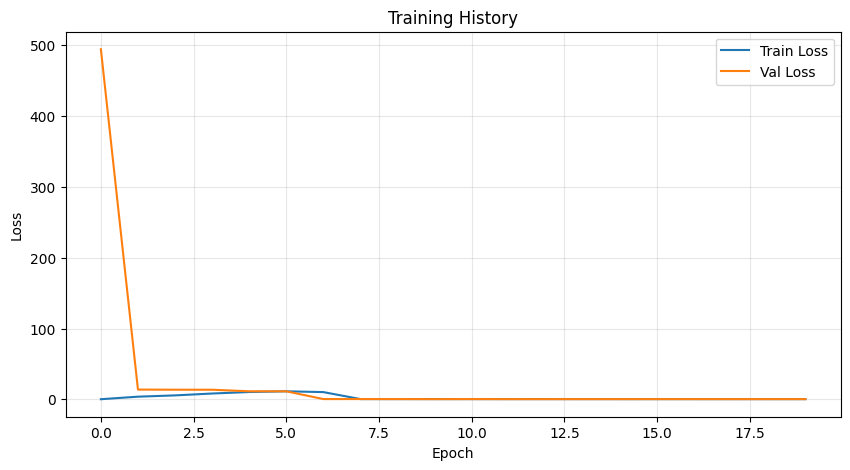


Visualizing latent space...


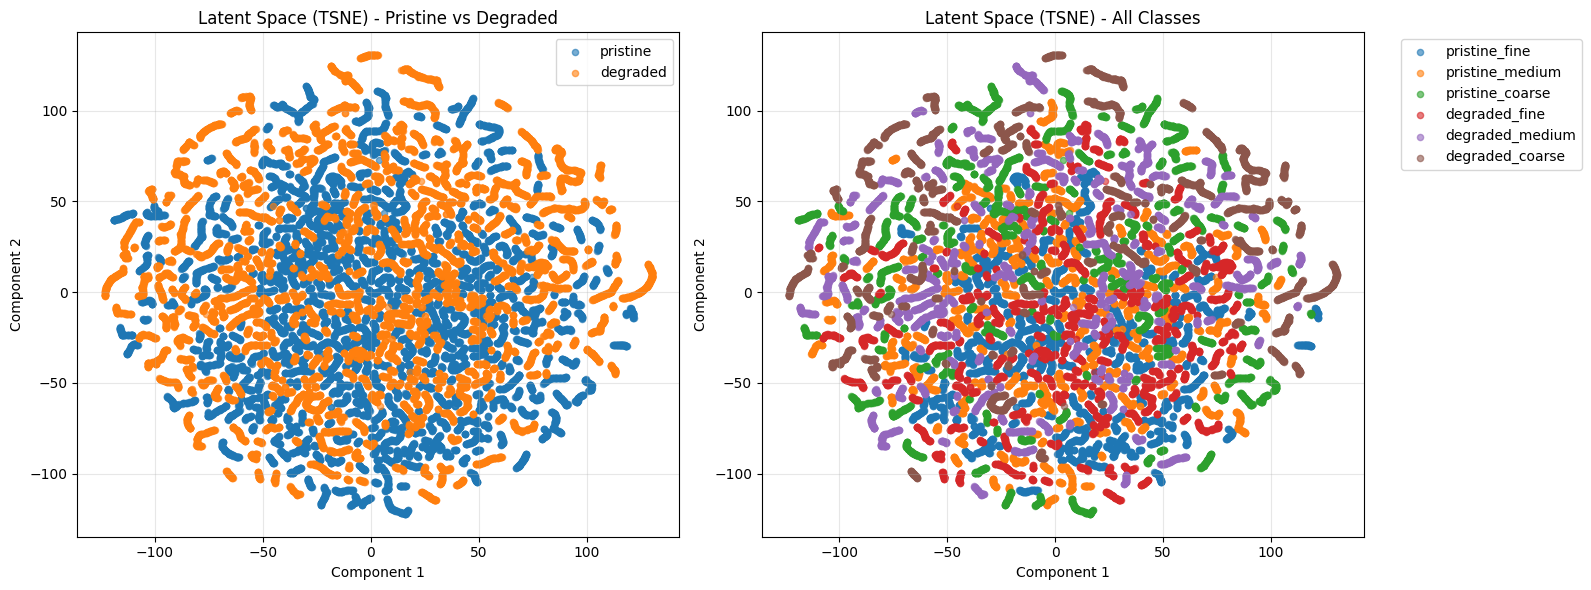

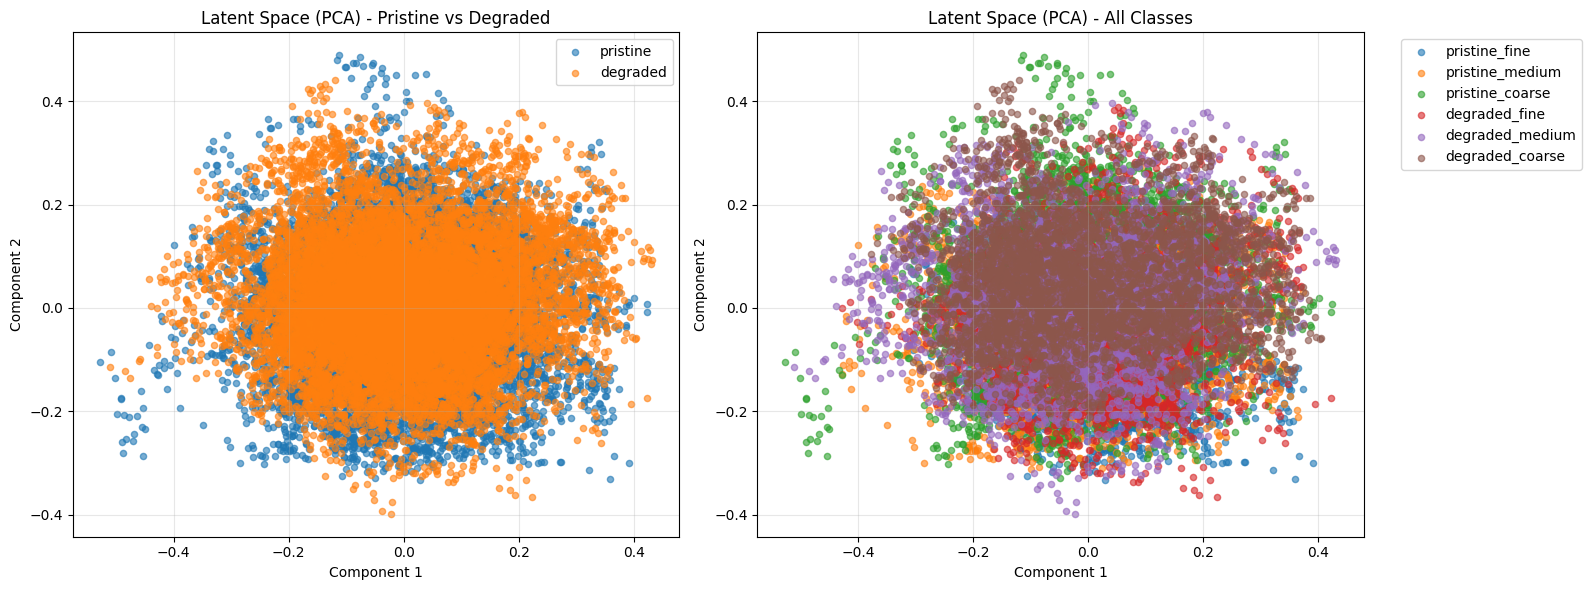


Visualizing reconstructions...


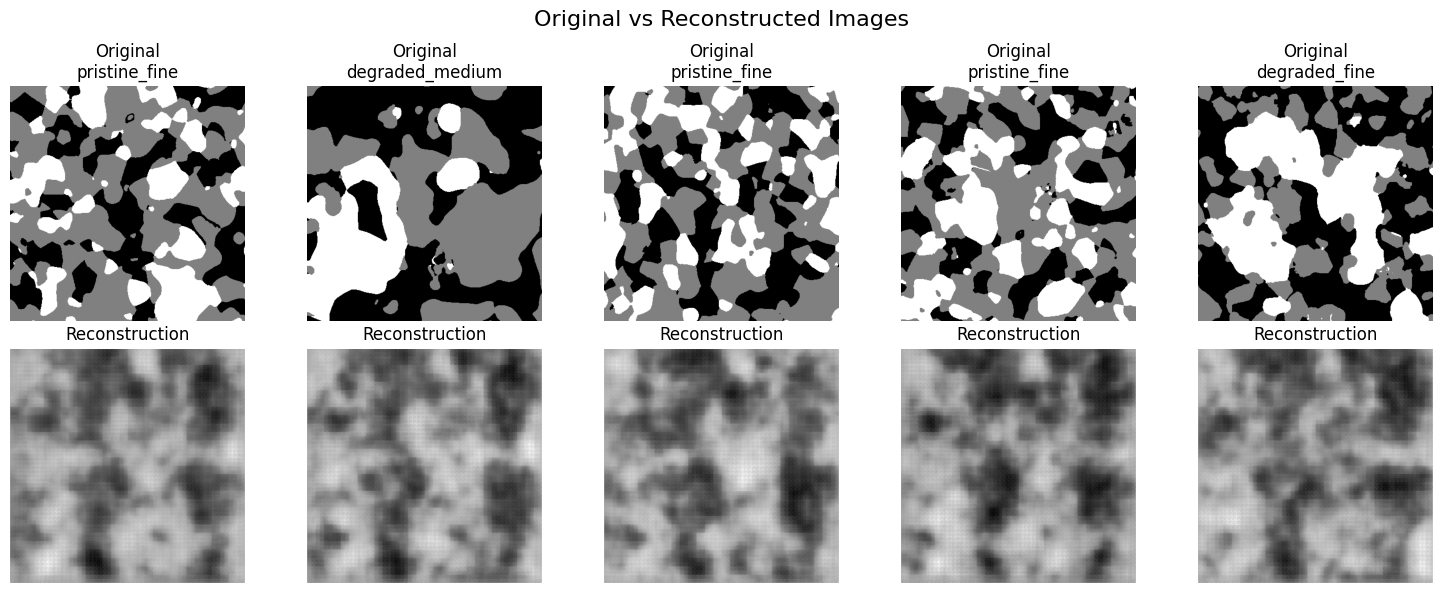


Latent Space Analysis:
Latent vectors shape: (24192, 32)
Distance between pristine_fine        and pristine_medium     : 0.0815
Distance between pristine_fine        and pristine_coarse     : 0.1296
Distance between pristine_fine        and degraded_fine       : 0.0656
Distance between pristine_fine        and degraded_medium     : 0.1246
Distance between pristine_fine        and degraded_coarse     : 0.1615
Distance between pristine_medium      and pristine_coarse     : 0.0646
Distance between pristine_medium      and degraded_fine       : 0.0439
Distance between pristine_medium      and degraded_medium     : 0.0517
Distance between pristine_medium      and degraded_coarse     : 0.0989
Distance between pristine_coarse      and degraded_fine       : 0.0897
Distance between pristine_coarse      and degraded_medium     : 0.0524
Distance between pristine_coarse      and degraded_coarse     : 0.0624
Distance between degraded_fine        and degraded_medium     : 0.0797
Distance between de

In [ ]:
if __name__ == "__main__":
    main()